# Food type Classification (transfer learning)


## Model customization

In [1]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 14
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False
      
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


## Data augmentation (to increase the size of our small dataset)

In [2]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32
TRAIN_DIR = 'train'
TEST_DIR = 'test'

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 291 images belonging to 14 classes.
Found 105 images belonging to 14 classes.


Plot some images result of data augmentation.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Transfer learning (retrain our model)

In [4]:
EPOCHS = 5
BATCH_SIZE = 20
STEPS_PER_EPOCH = 50
VALIDATION_STEPS = 10

MODEL_FILE = 'filename.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
50/50 [==============================] - 781s 16s/step - loss: 2.0214 - accuracy: 0.4014 - val_loss: 1.3593 - val_accuracy: 0.7299
Epoch 2/5
50/50 [==============================] - 720s 14s/step - loss: 1.1284 - accuracy: 0.7656 - val_loss: 0.7234 - val_accuracy: 0.8167
Epoch 3/5
50/50 [==============================] - 703s 14s/step - loss: 0.7846 - accuracy: 0.8557 - val_loss: 0.7500 - val_accuracy: 0.7774
Epoch 4/5
50/50 [==============================] - 736s 15s/step - loss: 0.6294 - accuracy: 0.8880 - val_loss: 0.3827 - val_accuracy: 0.8207
Epoch 5/5
50/50 [==============================] - 547s 11s/step - loss: 0.4684 - accuracy: 0.9155 - val_loss: 0.7198 - val_accuracy: 0.7299


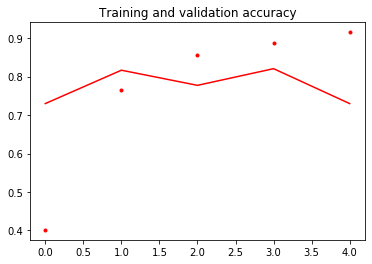

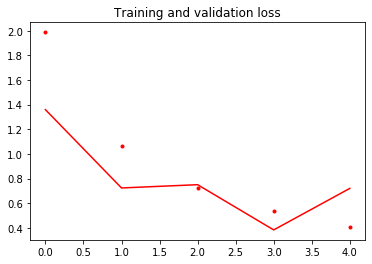

In [5]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

## Prediction (classify random image)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from keras.preprocessing import image
from keras.models import load_model


def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]


def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("Biscuits","Burger","Cheese pizza","Donuts","Egg roll","French fries","Fried Chicken","Hot Dog","Muffins","Noodles","Peperoni pizza","Sandwich","Shish_Kabab","Tacos")
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    plt.figure(figsize=(10,10))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    order = list(reversed(range(len(preds))))
    plt.bar(labels, preds, alpha=0.5)
#     plt.yticks(order, labels)
#     plt.xlabel(order)
    plt.xticks(rotation=30)
#     plt.xlim(0, 1.01)
#     plt.tight_layout()

In [7]:
model = load_model(MODEL_FILE)

array([2.6111677e-03, 8.1516548e-05, 1.4271200e-01, 1.8771812e-05,
       1.3164656e-04, 1.1512225e-05, 3.9308568e-05, 1.8925935e-05,
       1.6672822e-04, 1.4358731e-04, 8.5369164e-01, 1.1417697e-04,
       6.7566441e-05, 1.9141388e-04], dtype=float32)

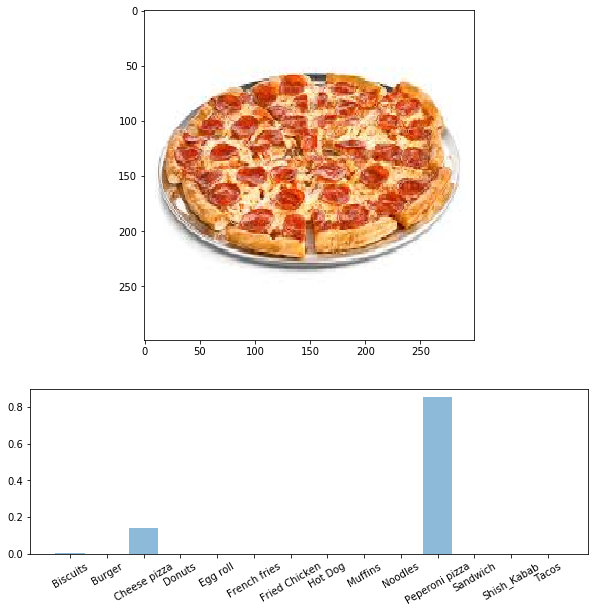

In [56]:
img = image.load_img('d.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds
